In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os, json, math, librosa

import IPython.display as ipd
import librosa.display

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D

import sklearn.model_selection as sk

from sklearn.model_selection import train_test_split


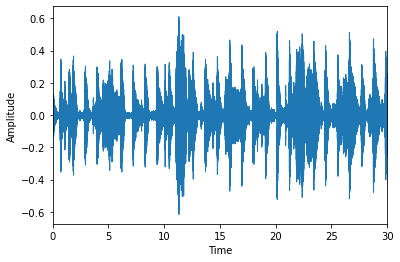

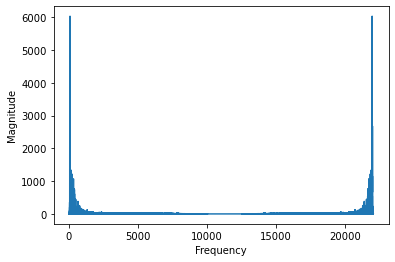

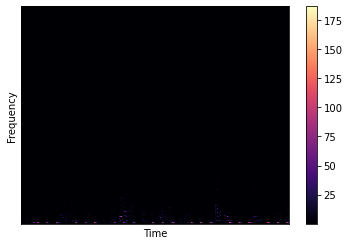

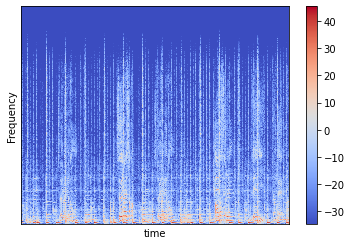

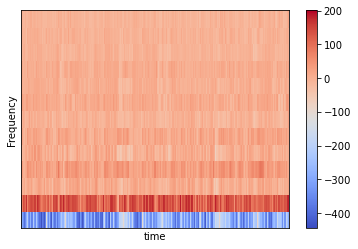

In [27]:
file="../input/gtzan-dataset-music-genre-classification/Data/genres_original/"
filename="blues/blues.00011.wav"
signal, sample_rate=librosa.load(str(file)+filename)
fft=np.fft.fft(signal) #complex number
magnitude = np.abs(fft) #absolute number
frequency=np.linspace(0,sample_rate,len(magnitude))
librosa.display.waveplot(signal,sample_rate)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()
plt.plot(frequency,magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()
n_fft=2048
hop_length=512
stft=librosa.core.stft(signal ,n_fft=n_fft)
spectogram=np.abs(stft)
librosa.display.specshow(spectogram,sr=sample_rate,hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()
log_spectogram= librosa.amplitude_to_db(spectogram)
librosa.display.specshow(log_spectogram,sr=sample_rate,hop_length=hop_length)
plt.xlabel("time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()
MFCCs=librosa.feature.mfcc(signal,n_fft=n_fft,hop_length=hop_length,n_mfcc=13)
librosa.display.specshow(MFCCs,sr=sample_rate,hop_length=hop_length)
plt.xlabel("time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()


In [28]:
# Getting Genres from folder name

MUSIC = '../input/gtzan-dataset-music-genre-classification/Data/genres_original/'
music_dataset = [] # File locations for each wav file 
genre_target = [] # 
for root, dirs, files in os.walk(MUSIC):
    for name in files:
        filename = os.path.join(root, name)
        if filename != '/data/genres_original/jazz/jazz.00054.wav':
            music_dataset.append(filename)
            genre_target.append(filename.split("/")[5])
            

In [29]:
# Displaying genres 

print(set(genre_target))

{'country', 'rock', 'pop', 'reggae', 'blues', 'disco', 'classical', 'jazz', 'metal', 'hiphop'}


In [30]:
# Testing Audio Files

audio_path = music_dataset[500]
# img_path = './data/images_original/blues/blues00011.png'

x , sr = librosa.load(audio_path)



librosa.load(audio_path, sr=None)

ipd.Audio(audio_path)



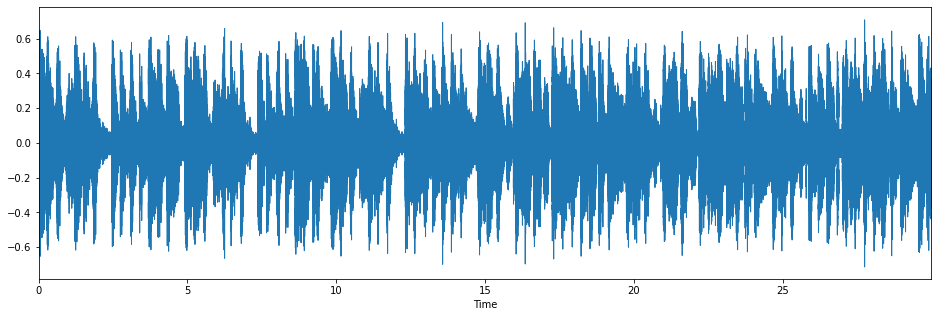

In [31]:
# Visualizing Audio File as a waveform
plt.figure(figsize=(16, 5))
librosa.display.waveplot(x, sr=sr)

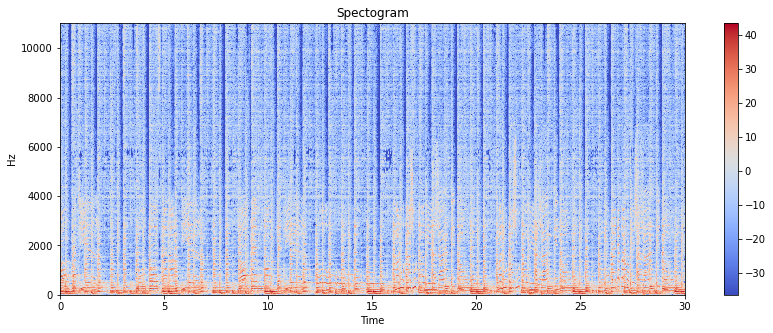

In [32]:
# Visualizing audio file as a spectogram
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.title('Spectogram')
plt.colorbar()



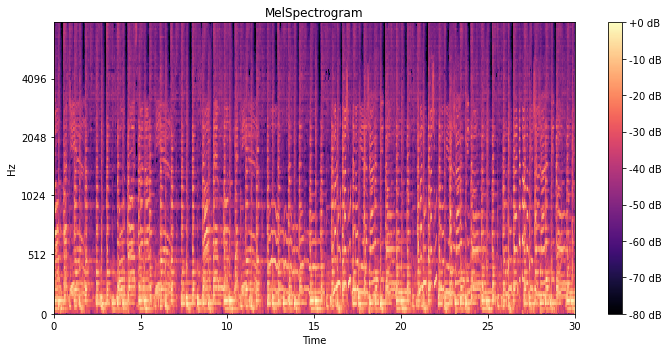

In [33]:
# Visualizing Audio as Mel-Spectogram

file_location = audio_path
y, sr = librosa.load(file_location)
melSpec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
melSpec_dB = librosa.power_to_db(melSpec, ref=np.max)
plt.figure(figsize=(10, 5))
librosa.display.specshow(melSpec_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+1.0f dB')
plt.title("MelSpectrogram")
plt.tight_layout()
plt.show()


In [34]:
DATASET_PATH = '../input/gtzan-dataset-music-genre-classification/Data/genres_original/'
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.
        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		# load audio file

                file_path = os.path.join(dirpath, f)
            
                if file_path != '../input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav':

                    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                
                
                    # process all segments of audio file
                    for d in range(num_segments):

                        # calculate start and finish sample for current segment
                        start = samples_per_segment * d
                        finish = start + samples_per_segment

                        # extract mfcc
                        mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                        mfcc = mfcc.T

                        # store only mfcc feature with expected number of vectors
                        if len(mfcc) == num_mfcc_vectors_per_segment:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [35]:
# Runs Data Processing     
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=6)


Processing: rock

Processing: classical

Processing: metal

Processing: disco

Processing: blues

Processing: reggae

Processing: country

Processing: hiphop

Processing: jazz

Processing: pop


In [36]:

DATA_PATH = "./data_10.json"


def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    z = np.array(data['mapping'])
    return X, y, z


def plot_history(history):
    fig, axs = plt.subplots(2)
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    plt.show()


def prepare_datasets(test_size, validation_size):
    # load data
    X, y, z = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test, z


def build_2layermodel(input_shape):

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.BatchNormalization())
    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model
def build_3layermodel(input_shape):

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    # 2nd conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    #3rd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model
def build_4layermodel(input_shape):

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    
    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    #4th conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)
    
    # get mappings for target and predicted label
    target = z[y]
    predicted = z[predicted_index]

    print("Target: {}, Predicted label: {}".format(target, predicted))




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 214, 11, 32)       320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 212, 9, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 212, 9, 64)        256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 122112)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                7815232   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

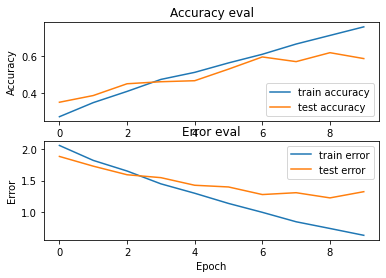

47/47 - 2s - loss: 1.3302 - accuracy: 0.5935

Test accuracy 2 layer CNN: 0.5934579372406006


In [37]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test, z = prepare_datasets(0.25, 0.2)

# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_2layermodel(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=10)

# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy 2 layer CNN:', test_acc)



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 214, 11, 32)       320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 212, 9, 64)        18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 210, 7, 32)        18464     
_________________________________________________________________
flatten_2 (Flatten)          (None, 47040)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                3010624   
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

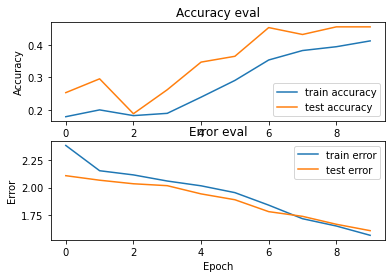

47/47 - 2s - loss: 1.6517 - accuracy: 0.4299

Test accuracy 3 layer CNN: 0.42990654706954956


In [38]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test, z = prepare_datasets(0.25, 0.2)

# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_3layermodel(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=10)

# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy 3 layer CNN:', test_acc)



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 214, 11, 32)       320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 212, 9, 32)        9248      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 211, 8, 32)        4128      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 210, 7, 32)        4128      
_________________________________________________________________
flatten_3 (Flatten)          (None, 47040)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                3010624   
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

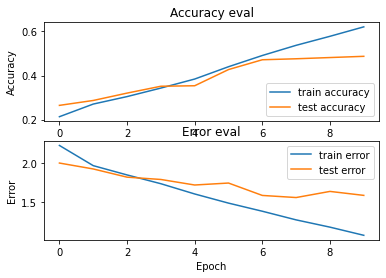

47/47 - 1s - loss: 1.6011 - accuracy: 0.4953

Test accuracy 4 layer CNN: 0.4953271150588989


In [39]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test, z = prepare_datasets(0.25, 0.2)

# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_4layermodel(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=10)

# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy 4 layer CNN:', test_acc)

